# Fitting a segment of the light curve of Kepler-62 with Sequential Monte Carlo via PyMC3

First let's download the light curve using `lightkurve`:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from lightkurve import search_lightcurvefile

lcf = search_lightcurvefile('Kepler-62', mission='Kepler').download_all()
lc = lcf.stitch()

//anaconda3/lib/python3.7/site-packages/lightkurve/collections.py:212: LightkurveWarning: Stitching a `LightCurveFileCollection` which contains both SAP and PDCSAP_FLUX. Plotting PDCSAP_FLUX. You can remove this warning by using `LightCurveFileCollection.PDCSAP_FLUX.stitch()`.
  LightkurveWarning)


In [3]:
t, f, e = lc.time[~np.isnan(lc.flux)], lc.flux[~np.isnan(lc.flux)], lc.flux_err[~np.isnan(lc.flux)]

(0.997, 1.003)

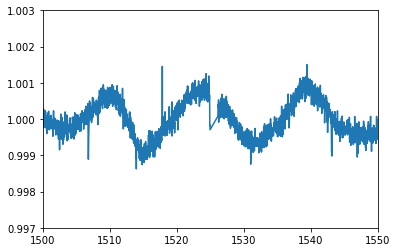

In [4]:
plt.plot(t, f)
plt.xlim([1500, 1550])
plt.ylim([0.997, 1.003])

Next let's extract just a segment of the light curve that's quasiperiodic:

In [5]:
t1, f1, e1 = t[(t < 1550) & (t > 1500)], f[(t < 1550) & (t > 1500)], e[(t < 1550) & (t > 1500)]

<ErrorbarContainer object of 3 artists>

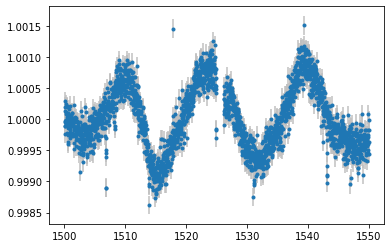

In [6]:
plt.errorbar(t1, f1, e1, fmt='.', ecolor='silver')

We'll implement the model in numpy first, so we can visualize things later: 

In [21]:
def numpy_model_seq(lat, lon, rspot, f0, period, contrast=0.7):
    
    spot_model = 1 + f0
    
    for i in range(len(lon)):
        spot_position_y = (np.pi/2 - lat[i]) / (np.pi / 2)
        spot_position_x = np.sqrt(1 - spot_position_y**2) * np.cos(2 * np.pi / period * t1 - lon[i])
        spot_position_z = np.sqrt(1 - spot_position_y**2) * np.sin(2 * np.pi / period * t1 - lon[i])
        rsq = spot_position_x**2 + spot_position_y**2
        spot_model -= rspot[i]**2 * (1 - contrast) * np.where(spot_position_z > 0, np.sqrt(1 - rsq), 0)
    return spot_model

In [22]:
m = numpy_model_seq([0.2, 0.1], [1.7 * np.pi, 2 * np.pi], [0.12, 0.05], 0.001, 17)

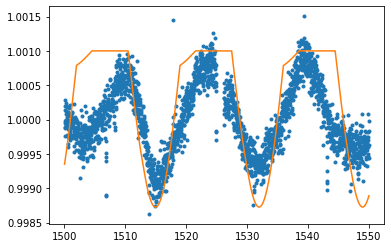

In [23]:
plt.plot(t1, f1, '.')
plt.plot(t1, m)

Implement the same model with PyMC3 assuming: 

* there are 3 spots
* the lat, lon, radius of spots are allowed to vary
* contrast = 0.7
* flux residuals are Student t-distributed (robust against outliers)
* spot radii are small compared to stellar radius
* spots don't evolve significantly over this timescale

In [15]:
import pymc3 as pm
from pymc3.smc import sample_smc
import theano

e1_tt = theano.shared(np.asarray(e1, dtype=theano.config.floatX), name='e1')

with pm.Model() as model1:

    f0 = pm.Uniform("f0", lower=0, upper=1)
    nu = pm.Uniform("nu", lower=1, upper=5)    
    spot_model = 1 + f0

    period = pm.Uniform("P", lower=15, upper=25)
    
    for spot_ind in range(3):
        rspot = pm.Uniform(f"R_spot_{spot_ind}", lower=0.05, upper=0.2)
        lon = pm.Uniform(f"lon_{spot_ind}", lower=0, upper=2*np.pi)
        lat = pm.Uniform(f"lat_{spot_ind}", lower=0, upper=np.pi)

        spot_position_y = (np.pi/2 - lat) / (np.pi / 2)
        spot_position_x = pm.math.sqrt(1 - spot_position_y**2) * pm.math.cos(2 * np.pi / period * t1 - lon)
        spot_position_z = pm.math.sqrt(1 - spot_position_y**2) * pm.math.sin(2 * np.pi / period * t1 - lon)
        rsq = spot_position_x**2 + spot_position_y**2
        contrast = 0.7
        spot_model -= rspot**2 * (1 - contrast) * pm.math.where(spot_position_z > 0, pm.math.sqrt(1 - rsq), 0)
    
    pm.StudentT("obs", mu=spot_model, nu=nu,
                sigma=e1_tt,
                observed=f1)
    
    trace1 = sample_smc(10000, n_steps=2, random_seed=42, 
                        cores=16, parallel=True)

Sample initial stage: ...
INFO:pymc3:Sample initial stage: ...
Stage:   0 Beta: 0.000 Steps:   2 Acce: 1.000
INFO:pymc3:Stage:   0 Beta: 0.000 Steps:   2 Acce: 1.000
Stage:   1 Beta: 0.000 Steps:   2 Acce: 0.417
INFO:pymc3:Stage:   1 Beta: 0.000 Steps:   2 Acce: 0.417
Stage:   2 Beta: 0.000 Steps:   2 Acce: 0.314
INFO:pymc3:Stage:   2 Beta: 0.000 Steps:   2 Acce: 0.314
Stage:   3 Beta: 0.000 Steps:   2 Acce: 0.253
INFO:pymc3:Stage:   3 Beta: 0.000 Steps:   2 Acce: 0.253
Stage:   4 Beta: 0.001 Steps:   2 Acce: 0.225
INFO:pymc3:Stage:   4 Beta: 0.001 Steps:   2 Acce: 0.225
Stage:   5 Beta: 0.001 Steps:   2 Acce: 0.204
INFO:pymc3:Stage:   5 Beta: 0.001 Steps:   2 Acce: 0.204
Stage:   6 Beta: 0.001 Steps:   2 Acce: 0.151
INFO:pymc3:Stage:   6 Beta: 0.001 Steps:   2 Acce: 0.151
Stage:   7 Beta: 0.002 Steps:   2 Acce: 0.127
INFO:pymc3:Stage:   7 Beta: 0.002 Steps:   2 Acce: 0.127
Stage:   8 Beta: 0.003 Steps:   2 Acce: 0.089
INFO:pymc3:Stage:   8 Beta: 0.003 Steps:   2 Acce: 0.089
Stage:   9

Make a corner plot showing the posterior distributions for each parameter: 

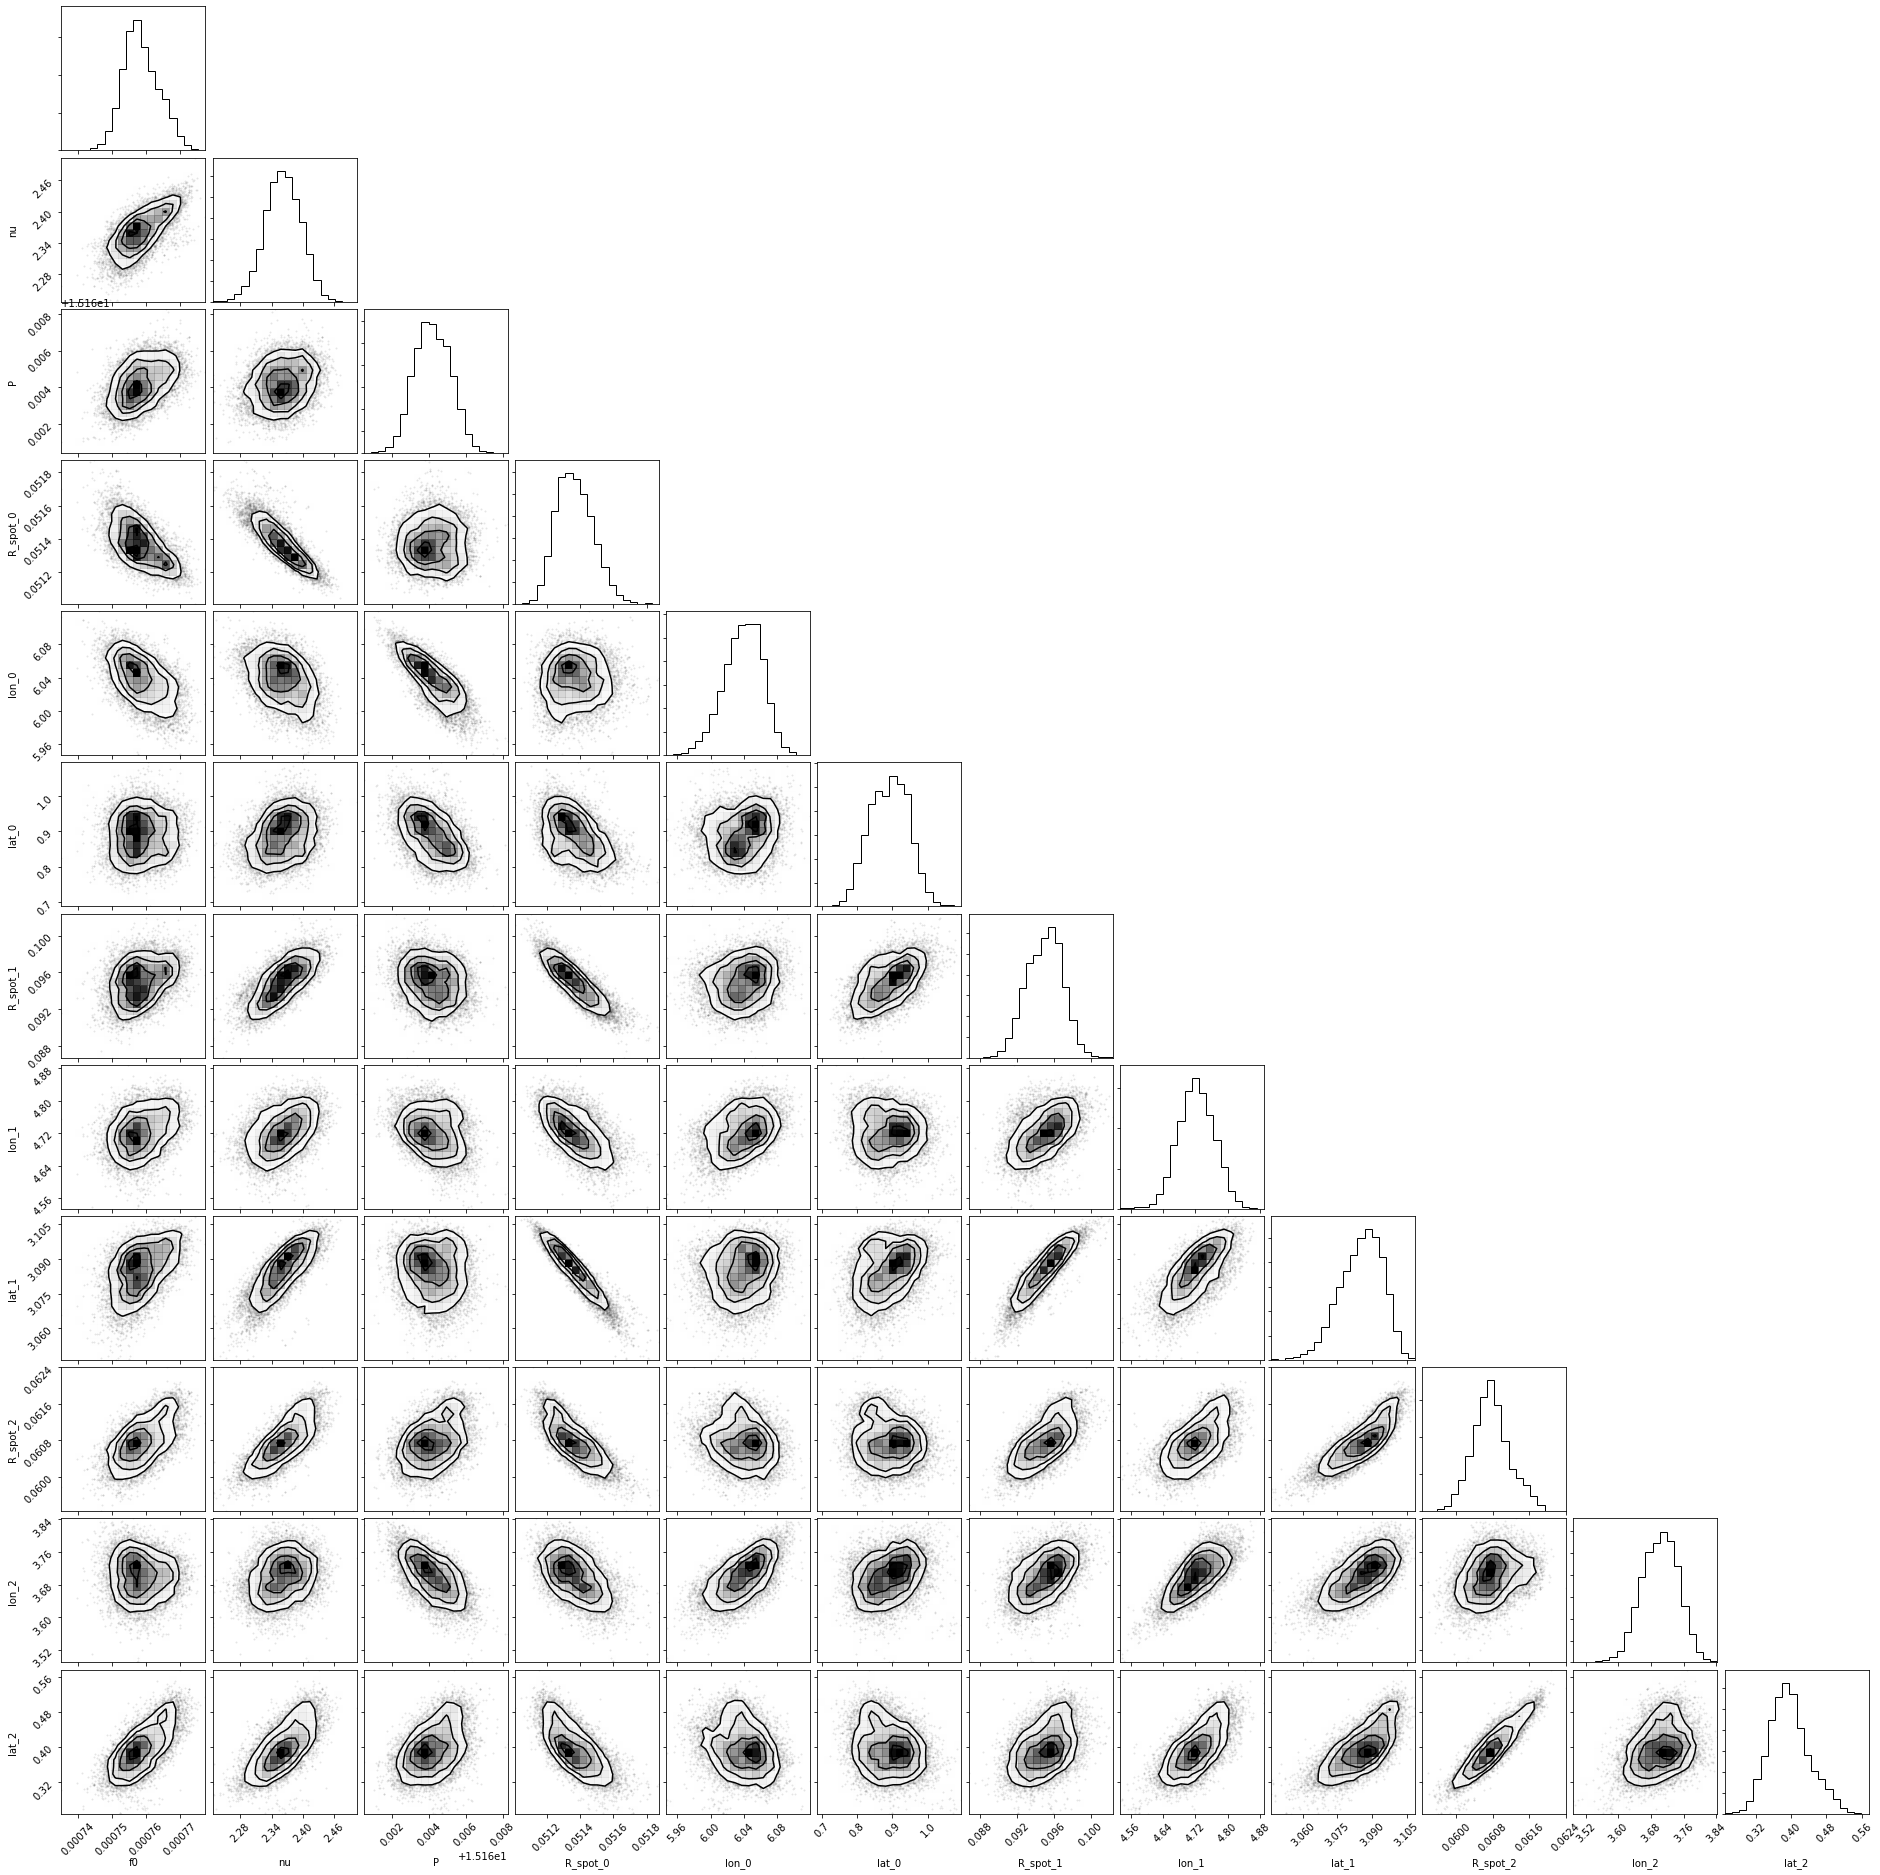

In [16]:
from corner import corner

corner(pm.trace_to_dataframe(trace1));

Plot the model evaluated at samples from the posterior distributions:

[0.05112035 0.09951405 0.06240344] [5.98035745 4.72669456 3.67281274]
[0.05120533 0.09797359 0.0609952 ] [6.05128168 4.77903093 3.75146479]
[0.05151536 0.09278292 0.0602774 ] [6.03378223 4.6500363  3.6438047 ]
[0.05118042 0.0967218  0.06170722] [6.01766267 4.7960116  3.6995173 ]
[0.05125111 0.09636911 0.06137179] [6.04537029 4.80753557 3.73700493]
[0.05119788 0.09923583 0.06149464] [6.05951271 4.80258066 3.76315076]
[0.05126255 0.09692835 0.0616046 ] [6.03453572 4.77995293 3.70632301]
[0.05124191 0.0958504  0.06141673] [6.04237508 4.80908105 3.75369692]
[0.05128132 0.09709921 0.06108066] [6.06011554 4.74586142 3.76958055]
[0.05131688 0.09608038 0.06090164] [6.04739037 4.70977364 3.7334275 ]


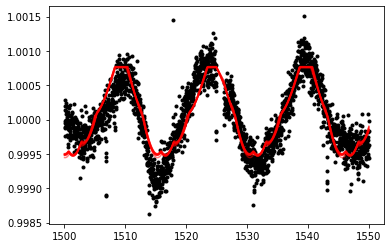

In [20]:
samples = pm.trace_to_dataframe(trace1).values
plt.plot(t1, f1, '.', color='k')

for s in samples[np.random.randint(0, samples.shape[0], size=10)]:
    f0, per, rspot, lon, lat = s[0], s[2], s[3::3], s[4::3], s[5::3]
    plt.plot(t1, numpy_model_seq(lat, lon, rspot, f0, per), color='r', alpha=0.5)
    
plt.gca().set(xlabel='Tim')
plt.show()